**Introduction**
*   In this project, we will walk through how to build an LSTM-based Neural Translation (Sequence-to-Sequence) model from scratch.
*   This project is beginner-friendly but basic understanding in NN and NLP will be assumed.
*   We will cover topics like Text Preprocessing, Padding, Masking, Embedding, LSTM (you can substitue with RNN or GRU), Encoder / Decoder Architecture, Perplexity, and more.
*   I will use TensorFlow's functional API to create standard model structures (you can use Sequential if it is preferred). And for custom layers and training loops, the Subclassing API will be used.
*   I have kept everything on a Jupyter Notebook format in hopes to provide a clearer workflow and step-by-step explanations. A PDF version will also be provided in case you don't want to execute the codes.
*   I am a graduate student at McMaster University and this is my first post on Github. If you have any suggestion for my code, or questions, please feel free to reach out to me on LinkedIn: https://www.linkedin.com/in/saberyu/.













Credits: this project is inspired by my own Capstone project from the specialization on Coursera, "TensorFlow 2 for Deep Learning", provided by Dr. Kevin Webster and his team at Imperial College Lodon. It is a wonderful specialization and I stronger recommend you to check it out if you would like to learn more about TensorFlow.

**Let's get started wiht some imports**

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import unicodedata
import re
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Layer, Masking, Input, LSTM, Embedding, Dense, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import RandomNormal
from google.colab import drive

**Let's dive into the data**

The data we are going to use in this project are bilingual sentence pairs (perfect for a Seq-2-Seq model) and can be downloaded from http://www.manythings.org/anki/. The Japanese-English set has been downloaded and stored on my Google Drive. So here we will first need to mount the drive and access the data from there.

In [2]:
# mount Google Drive
drive.mount('/content/gdrive')

# load the dataset
data_examples = []
with open('/content/gdrive/My Drive/Seq2seq_model/jpn.txt', 'r', encoding='utf8') as f:
    data_examples = f.readlines()

Mounted at /content/gdrive


Now that the data have been loaded, let's take a look at some examples to get a feeling of what they look like.

In [3]:
# first take a look at the data
for i, line in enumerate(data_examples[:5],1):
    print(f"{i}. {line.strip()}")
print("-"*100)
print(f"There are {len(data_examples)} samples in the data.")

1. Go.	行け。	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #7421985 (Ninja)
2. Go.	行きなさい。	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #7421986 (Ninja)
3. Hi.	こんにちは。	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #373351 (tommy_san)
4. Hi.	もしもし。	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #385517 (mookeee)
5. Hi.	やっほー。	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #3480285 (arnab)
----------------------------------------------------------------------------------------------------
There are 109964 samples in the data.


We can see that for each sentence pair, the English words and the Japanese words are separated by a tab. This allows us to split them into two isolated lists, one contains only English and the other only Japanese. Also we won't need the attribution statement in the end.

**Preprocess the data**

Here we will separate the English-Japanese pairs into two lists and preprocess them to exclude any characters that we don't want to see in the final data. We will also normalize the strings into a standardized form using Unicode.

To be specific, we will perform the following:
*   **sentence.lower().strip()** converts the sentence to lowercase and strip it
*   **unicodedata.normalize('NFC', sentence)** standardizes the characters, different languge uses different arguement here, NFC recommended for English, and for Japanese it is NFKC.
*   **re.sub(r"([?.!,])", r" \1 ", sentence)** adds spaces around punctuation
*   **re.sub(r"[^a-z0-9?.!,'-]+", " ", sentence)** keeps only valid characters, numbers, and hyphens.
*   **re.sub(r'[" "]+', " ", sentence)** removes extra spaces







In [4]:
# define a preprocess function for the English sentences
def preprocess_english(sentence):
    sentence = sentence.lower().strip()
    sentence = unicodedata.normalize('NFC', sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-z0-9?.!,'-]+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    return sentence.strip()

# define a preprocess function for the Japanese sentences
def preprocess_japanese(sentence):
    sentence = sentence.strip()
    sentence = unicodedata.normalize("NFKC", sentence)
    sentence = re.sub(r"([?.!,？。！、])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    return sentence.strip()

In [5]:
# preprocess and separate the English and Japanese data
english_sequences = []
japanese_sequences = []

for data in data_examples:
    splits = data.split('\t')

    english_words=preprocess_english(splits[0]) # send the first element (English) to the preprocess function
    japanese_words=preprocess_japanese(splits[1]) # send the second element (Japanese)

    english_sequences.append(english_words)
    japanese_sequences.append(japanese_words)

print(english_sequences[0:5])
print(japanese_sequences[0:5])

['go .', 'go .', 'hi .', 'hi .', 'hi .']
['行け 。', '行きなさい 。', 'こんにちは 。', 'もしもし 。', 'やっほー 。']


**Prepare the Japanese data**

Next step. We will process the Japanese data further and have them tokenized. We will use MeCab to split the Japanese characters into the smallest meaningful units. We will insert two tokens, "start" and "end", into the sequences, and then we will use a TensoFlow tokenizer to tokenize everything.

In [6]:
# first, let's run the code below to install MeCab
!apt install -y mecab mecab-ipadic-utf8
!pip install mecab-python3 unidic-lite

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libmecab2 mecab-ipadic mecab-utils
The following NEW packages will be installed:
  libmecab2 mecab mecab-ipadic mecab-ipadic-utf8 mecab-utils
0 upgraded, 5 newly installed, 0 to remove and 20 not upgraded.
Need to get 7,062 kB of archives.
After this operation, 56.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libmecab2 amd64 0.996-14build9 [199 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 mecab-utils amd64 0.996-14build9 [4,850 B]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 mecab-ipadic all 2.7.0-20070801+main-3 [6,718 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 mecab amd64 0.996-14build9 [136 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/main amd64 mecab-ipadic-utf8 all 2.7.0-20070801+main-3 [4,384 B]
Fetched 7,062 kB in 0s (15.8 MB/

In [7]:
# use MeCab to separate the Japanese words meaningfully (a.k.a. Morphological Units in linguistics)
import MeCab
mecab = MeCab.Tagger("-Owakati")
mecab_japanese = [mecab.parse(sentence).strip() for sentence in japanese_sequences]

In [8]:
# we will add a <start> and <end> tokens to Japanese sequences
tagged_japanese = []
for sequence in mecab_japanese:
    sequence = f"<start> {sequence} <end>"
    tagged_japanese.append(sequence)

print(tagged_japanese[0:3])

['<start> 行け 。 <end>', '<start> 行き なさい 。 <end>', '<start> こんにちは 。 <end>']


In [9]:
# set up tokenizer and tokenize the Japanese sequences
tokenizer = Tokenizer(num_words=None,
                      filters='',
                      split=' ',
                      char_level=False)

tokenizer.fit_on_texts(tagged_japanese)
tokenized_japanese = tokenizer.texts_to_sequences(tagged_japanese)

In [10]:
# let's have a look at some examples from the processed data
for i in range(5):
    indice = random.randint(0,109964)
    print('For indice', indice)
    print('English:', english_sequences[indice])
    print('Japanese:', japanese_sequences[indice])
    print('MeCab Japanese:', mecab_japanese[indice])
    print('Tagged Japanese:', tagged_japanese[indice])
    print('Tokenized Japanese:', tokenized_japanese[indice])
    print('-'*100)

For indice 92891
English: cows are considered sacred animals in india .
Japanese: インドでは牛は神聖な生き物とされています 。
MeCab Japanese: インド で は 牛 は 神聖 な 生き物 と さ れ て い ます 。
Tagged Japanese: <start> インド で は 牛 は 神聖 な 生き物 と さ れ て い ます 。 <end>
Tokenized Japanese: [1, 2204, 16, 4, 1719, 4, 8828, 26, 4725, 23, 74, 64, 9, 28, 25, 3, 2]
----------------------------------------------------------------------------------------------------
For indice 109557
English: were you able to make it to the station on time to catch the first train this morning ?
Japanese: 今朝の始発電車に間に合うように 、 時間通り駅に着くことはできたの ?
MeCab Japanese: 今朝 の 始発 電車 に 間に合う よう に 、 時間 通り 駅 に 着く こと は でき た の ?
Tagged Japanese: <start> 今朝 の 始発 電車 に 間に合う よう に 、 時間 通り 駅 に 着く こと は でき た の ? <end>
Tokenized Japanese: [1, 528, 5, 2971, 263, 7, 1269, 66, 7, 11, 93, 351, 235, 7, 1106, 30, 4, 71, 6, 5, 15, 2]
----------------------------------------------------------------------------------------------------
For indice 2889
English: you're weird .
Japanese: あんた変だよ 。
Me

Let's also find out the max length of a sequence and the vocab size. The maximum length of a sequence is used to set up the padding size for all sequences. This way we make sure all sequences have the same input length and then we will convert them into a numpy array. The vocab size will be used later when we set up the model.

In [11]:
# max length of a sequence
max_length = max(len(seq) for seq in tokenized_japanese)
print("Maximum sequence length:", max_length)

# and vocab size
unique_tokens = set(np.concatenate(tokenized_japanese))
vocab_size = len(unique_tokens)
print("Vocab size:", vocab_size)

Maximum sequence length: 93
Vocab size: 18671


In [12]:
# pad the tokenized Japanese to make sure all sequences have the same input length and convert them into a numpy array
padded_japanese = tf.keras.preprocessing.sequence.pad_sequences(
    tokenized_japanese,
    maxlen= max_length,
    padding='post')
padded_japanese = np.array(padded_japanese)

print(tagged_japanese[75706])
print('-'*80)
print(padded_japanese[75706])

<start> 決定 は 君 に 任せる よ 。 <end>
--------------------------------------------------------------------------------
[   1 2262    4   73    7 3768   18    3    2    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]


**Make TensorFlow Datasets and prepare English Data**

To prepare the data for training and testing our model, we will make two tf datasets (one for training, the other for testing). This is done using tf.data.Dataset.from_tensor_slices(). We will use a train/test split of 80/20.

In [13]:
# create the train / test split
x_train, x_test, y_train, y_test  = train_test_split(english_sequences, padded_japanese, test_size=0.2, random_state=42)

In [14]:
# make tf dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

Now, we will use a pre-trained embedding layer from TensorFlow Hub to convert the English strings into a 128-dimensional vector space. You can check out the model if you like by accessing: https://www.tensorflow.org/hub. The code I used below for loading this pre-trained model is provided on their website.

In [15]:
# load the model as our embedding layer for the Enlighs sequences
embedding_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2")

In the following four code cells, we will process the English data (inside the dataset) further.

The steps are as follows:
*   Split the sequences into individual string tokens
*   Apply the embedding layer on the x element of the datasets
*   Find out the maximum sequence length from both train and test datasets
*   Pad the sequences to Max Sequence Length +1 (because we will be adding a special marker token in the end of the English sequences)



In [16]:
# split the English sequences to make individual English tokens
def split(x, y):
    return (tf.strings.split(x), y)
train_dataset = train_dataset.map(split)
test_dataset = test_dataset.map(split)

In [17]:
# embed the English sequences. remeber the model takes strings and output 128-dimensional vectors
def embedding(x, y):
    return (embedding_layer(x),y)
train_dataset = train_dataset.map(embedding)
test_dataset = test_dataset.map(embedding)

In [18]:
# find out the max sequence length in both train_dataset and test_dataset
def get_max_seq_len(dataset):
    def reduce_func(accum, element):
        x, y = element
        seq_len = tf.shape(x)[0]
        return tf.maximum(accum, seq_len)
    max_len_tf = dataset.reduce(
        initial_state=tf.constant(0, dtype=tf.int32),
        reduce_func=reduce_func)
    return max_len_tf.numpy()

combined_dataset = train_dataset.concatenate(test_dataset)
max_len = get_max_seq_len(combined_dataset)
print("Max sequence length: ", max_len)

Max sequence length:  66


In [19]:
# pad the English sequences to max length + 1 (becasue we will add a special marker token in the end)
def pad_english(x, y):
    padding_needed =  max_len + 1 - tf.shape(x)[0]
    x_padded = tf.pad(x, [[0, padding_needed], [0, 0]], mode="CONSTANT")
    return x_padded, y
train_dataset = train_dataset.map(pad_english)
test_dataset = test_dataset.map(pad_english)

We are done with the Englihs data. Let's put the dataset into batches for training. We will use a batch_size of 16.

In [20]:
# batch the dataset
train_dataset = train_dataset.batch(16)
test_dataset = test_dataset.batch(16)

print(train_dataset.element_spec)

(TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(None, 93), dtype=tf.int32, name=None))


In [21]:
# you can have a look at the shape of the English and Japanese batches here
for x, y in train_dataset.take(1):
    print(tf.shape(x))
for x, y in test_dataset.take(1):
    print(tf.shape(y))

tf.Tensor([ 16  67 128], shape=(3,), dtype=int32)
tf.Tensor([16 93], shape=(2,), dtype=int32)


**Create a Learnable End Token**

We will create a special end token whose parameters are learnable throughout model training. This allows the model to use whatever weights it likes to mark the boundary of the input sequence.

In [22]:
# build a custom layer using the sub-classing API
class add_end(Layer):

    def __init__(self, embedding_dim, **kwargs):
        super(add_end, self).__init__(**kwargs)
        self.embedding_dim = embedding_dim

    def build(self, input_shape):
        self.end_tok = self.add_weight(shape=(1, 1, self.embedding_dim), initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                                       trainable=True, name='end_token')

    def call(self, inputs):
        end_token = tf.tile(self.end_tok, [tf.shape(inputs)[0], 1, 1])
        output = tf.concat([inputs, end_token], axis=1)
        return output

# create the custom layer
add_end_token_layer = add_end(128)

In [23]:
# we will print the shape of the English sequence before and after passing it into the layer to make sure it is correctly done
for x, y in train_dataset.take(1):
    x_added = add_end_token_layer(x)
    print(tf.shape(x))
    print(tf.shape(x_added))

tf.Tensor([ 16  67 128], shape=(3,), dtype=int32)
tf.Tensor([ 16  68 128], shape=(3,), dtype=int32)


**Let's build the Model**

The model we are going to build contains an encoder and a decoder. A visualization is provided below.


 The hidden state and the cell state from the last LSTM output of the encoder will be used as the initial states for the first LSTM layer of the decoder. This allows the decoder to generate a Japanese text conditioned on the input English sequence.

 You can replace the LSTM layers with RNN, or GRU. You can also stack multiple LSTMs together, and make them bi-directional. The results will differ based on what is built into the model. You can run some experiment to see if you can achieve even better results!



                       ┌─────────────────────────────┐
                       │        LSTM Encoder         │
             English ─►                              │
                       │   outputs h_state, c_state  │
                       └─────────────────────────────┘
                                     │
                                     ▼
                       ┌─────────────────────────────┐
                       │        LSTM Decoder         │
                       │                             │
                       │     uses h_state, c_state   │
                       │     from encoder as its     │
                       │     initial states          │
                       │                              ─► Japanese
                       └─────────────────────────────┘


**Encoder**

In [24]:
# let's build the encoder, we will use the functional API
inputs = Input(shape=(max_len +1, 128))
x = add_end_token_layer(inputs)
x = Masking(mask_value=0.0, name='masking')(x)
lstm_out, state_h, state_c = LSTM(512, return_state=True, return_sequences=False, kernel_initializer=tf.keras.initializers.GlorotUniform(), use_cudnn=False)(x)

model_encoder = Model(inputs, [state_h, state_c], name='Encoder')

In [25]:
# send English sequences into the model and see what we get
for x, y in train_dataset.take(1):
    the_code = model_encoder(x)
    print(tf.shape(x))
    print(tf.shape(the_code)) # the code that is sent to the decoder should contain hidden_state and cell_state

tf.Tensor([ 16  67 128], shape=(3,), dtype=int32)
tf.Tensor([  2  16 512], shape=(3,), dtype=int32)


In [26]:
# let's take a look at the encoder architecture below
model_encoder.summary()

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 67, 128)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_end (add_end)         │ (None, 68, 128)        │            128 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 68, 128)        │              0 │ add_end[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ masking (Masking)         │ (None, 68, 128)        │              0 │ add_end[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ any (Any)                 │ (None, 68)             │              0 │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 512), (None,   │      1,312,768 │ masking[0][0],         │
│                           │ 512), (None, 512)]     │                │ any[0][0]              │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,312,896 (5.01 MB)

 Trainable params: 1,312,896 (5.01 MB)

 Non-trainable params: 0 (0.00 B)

**Decoder**

In [27]:
# create the decoder
class get_decoder(Model):

    def __init__(self, **kwargs):
        super(get_decoder, self).__init__(**kwargs)
        self.embedding = Embedding(input_dim=vocab_size +1, output_dim=128, mask_zero=True) # vocab_size+1 beacuse of paddings
        self.decoder_lstm = LSTM(512, return_state=True, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(), use_cudnn=False)
        self.layer_norm = LayerNormalization()
        self.dense = Dense(vocab_size+1, kernel_initializer=RandomNormal(stddev=0.01))

    def call(self, inputs, initial_state=None):
        x = self.embedding(inputs)
        x, state_h, state_c = self.decoder_lstm(x, initial_state=initial_state)
        x = self.layer_norm(x)
        output = self.dense(x)
        return output, state_h, state_c

model_decoder = get_decoder()

In [28]:
# verify the output
for x, y in train_dataset.take(1):
    hidden_state, cell_state = model_encoder(x)
    decoder_output, state_h, state_c = model_decoder(y, initial_state=[hidden_state, cell_state])
    print(tf.shape(y))
    print(tf.shape(decoder_output))
    print(tf.shape(state_h))
    print(tf.shape(state_c))

tf.Tensor([16 93], shape=(2,), dtype=int32)
tf.Tensor([   16    93 18672], shape=(3,), dtype=int32)
tf.Tensor([ 16 512], shape=(2,), dtype=int32)
tf.Tensor([ 16 512], shape=(2,), dtype=int32)


In [29]:
model_decoder.summary()

Model: "get_decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (16, 93, 128)               │       2,390,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ((16, 93, 512), (16, 512),  │       1,312,768 │
│                                      │ (16, 512))                  │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization                  │ (16, 93, 512)               │           1,024 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (16, 93, 18672)             │       9,578,736 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,282,544 (50.67 MB)

 Trainable params: 13,282,544 (50.67 MB)

 Non-trainable params: 0 (0.00 B)

**Create a custom training loop**

*   The model is pretty much ready at this stage. We will define the training process. The custom training loop below allows you to see what goes where and how exactly things are calculated.
*   The first step is to split the Japanese sequence into two parts, one is the input for the decoder, the other is the label that the decoder compares to for calculating the loss function.
*   The decoder LSTM, at each time step, produces one predicted token, which would be compared to the ground truth (at this particular time step). The loss value will be calculated and kept till the end of the batch to compute an averaged loss. The model will then update its weights based on this averaged loss.
*   How LSTMs work is not in the scope of this notebook, but if you are interested in delving deeper into the this topic, I recommend checking out https://colah.github.io/posts/2015-08-Understanding-LSTMs/ and a Youtube video called "Long Short-Term Memory (LSTM), Clearly Explained" by StatQuest with Josh Starmer.




In [30]:
# function below to create the decoder input / label
def prepare_decoder(data):
    decoder_input_japanese = data[:,:-1]
    ground_truth_japanese = data[:,1:]
    return decoder_input_japanese, ground_truth_japanese

*   Below, we will define the loss function and the optimizer.
*   I used SparseCategoricalCrossentropy with 2 arguments.
*   **from_logits=True** allows the probabilities to be calculated directly from the logit outputs of the decoder LSTM
*   **reduction='none'** stops the loss function from automatically summing across all tokens and allows us to calculate the loss manualy with considerations for paddings.

In [31]:
# identify the loss function and the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

*   Next, we will define the forward and backward pass for the model.
*   @tf.function at the very top allows TensorFlow to construct sort of a blueprint of the computational graph and then execute the codes in a optimized way to speed up training. Without this, the code will run eager execution (line by line, not optimized for training efficiency but might be good for troubleshooting).
*   As explained previously, the English inputs from our dataset will be sent to the encoder to get its final hidden_state and cell_state from the LSTM layer. These will be used by the decoder LSTM as initial_state.
*   The loss is then calculated manualy considering paddings. Next, since both of our encoder and decoder are built from scratch, we will combine all the trainable weights from these two models together for updates. In other cases where a pre-trained English encoder is used, and it is doing a good job extracting the features from the English input, you can just update the weights in the decoder.
*   After that, we will compute the graident, which will be used by the optimizer to update the model's parameters.
*   Finally, in the training loop, we put everything together and use two metrics to evaluate the model, loss and perplexity. I am sure you are familiar with loss, but if you want, you can read more about perplexity. It basically measures how many equally likely options there are for the model to pick from for its output. The lower it is, the more "correct" and "confidnet" the model is.
*   I have read somewhere before that a good model should have a perplexity under 60 but I can't find the reference. I ran this by ChatGPT o1 and was told that it is typically somewhere between 10 and 40.












In [32]:
# create a function to compute the forward and backward pass
@tf.function
def grad(encoder, decoder, English_input, decoder_input_japanese, ground_truth_japanese):
    with tf.GradientTape() as tape:
        hidden_state, cell_state = encoder(English_input)
        decoder_output, _, _ = decoder(decoder_input_japanese, initial_state=[hidden_state, cell_state])
        loss_per_token = loss_object(y_true=ground_truth_japanese, y_pred=decoder_output)
        mask = tf.cast(tf.not_equal(ground_truth_japanese, 0), tf.float32)
        loss_per_token *= mask
        loss_value = tf.reduce_sum(loss_per_token) / tf.reduce_sum(mask)
        trainable_vars = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss_value, trainable_vars)
    return loss_value, gradients

def custom_training(num_epochs, train_dataset, test_dataset, encoder, decoder, optimizer):
    train_loss_results = []
    val_loss_results = []
    train_perplexity_results = []
    val_perplexity_results = []

    for epoch in range(num_epochs):
        epoch_loss_avg = tf.keras.metrics.Mean()
        val_loss_avg = tf.keras.metrics.Mean()
        epoch_perplexity_avg = tf.keras.metrics.Mean()
        val_perplexity_avg = tf.keras.metrics.Mean()
        start_time = time.time()
        # compute the training loop
        for english_input, japanese_input in train_dataset:
            decoder_input_japanese, ground_truth_japanese = prepare_decoder(japanese_input)
            loss_value , grads = grad(encoder, decoder, english_input, decoder_input_japanese, ground_truth_japanese)
            trainable_vars = encoder.trainable_variables + decoder.trainable_variables
            optimizer.apply_gradients(zip(grads, trainable_vars))
            epoch_loss_avg(loss_value)
            epoch_perplexity_avg(tf.exp(loss_value))
        for english_input, japanese_input in test_dataset:
            decoder_input_japanese, ground_truth_japanese = prepare_decoder(japanese_input)
            val_loss_value , _ = grad(encoder, decoder, english_input, decoder_input_japanese, ground_truth_japanese)
            val_loss_avg(val_loss_value)
            val_perplexity_avg(tf.exp(val_loss_value))

        # end epoch
        train_loss_results.append(epoch_loss_avg.result())
        val_loss_results.append(val_loss_avg.result())
        train_perplexity_results.append(epoch_perplexity_avg.result())
        val_perplexity_results.append(val_perplexity_avg.result())
        epoch_time = (time.time() - start_time)/60
        print(f"Epoch {epoch}, Training Loss {epoch_loss_avg.result():.4f}, Validation Loss {val_loss_avg.result():.4f}, Training Perplexity {epoch_perplexity_avg.result():.4f}, Validation Perplexity {val_perplexity_avg.result():.4f}")
        print(f"Epoch {epoch} took {epoch_time:.2f} min to train.")
    return train_loss_results, val_loss_results, train_perplexity_results, val_perplexity_results

We will train the model for 5 epochs, which takes about 1.5 hours. If you have stacked multiple LSTMs together or make them bidirectional. The training process might take longer to complete. Also, make sure you are ultizing a GPU.

In [33]:
# train the model

train_loss_results, val_loss_results, train_perplexity_results, val_perplexity_results = custom_training(5, train_dataset, test_dataset,
                                                                                                         model_encoder, model_decoder, optimizer)

Epoch 0, Training Loss 3.2799, Validation Loss 2.6714, Training Perplexity 50.5596, Validation Perplexity 15.0738
Epoch 0 took 18.42 min to train.
Epoch 1, Training Loss 2.3029, Validation Loss 2.5482, Training Perplexity 10.3994, Validation Perplexity 13.4830
Epoch 1 took 18.38 min to train.
Epoch 2, Training Loss 1.9652, Validation Loss 2.5567, Training Perplexity 7.3622, Validation Perplexity 13.7423
Epoch 2 took 18.33 min to train.
Epoch 3, Training Loss 1.7895, Validation Loss 2.5021, Training Perplexity 6.1556, Validation Perplexity 13.0774
Epoch 3 took 18.46 min to train.
Epoch 4, Training Loss 1.6841, Validation Loss 2.5149, Training Perplexity 5.5319, Validation Perplexity 13.2987
Epoch 4 took 18.39 min to train.


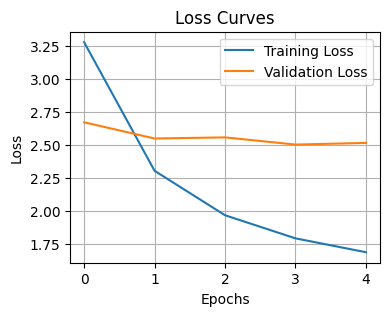

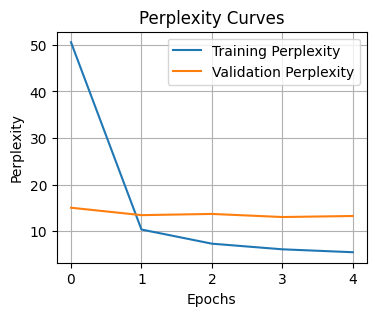

In [34]:
# Plot the Loss
plt.figure(figsize=(4, 3))
plt.plot(train_loss_results, label='Training Loss')
plt.plot(val_loss_results, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

# Plot the Perplexity
plt.figure(figsize=(4, 3))
plt.plot(train_perplexity_results, label='Training Perplexity')
plt.plot(val_perplexity_results, label='Validation Perplexity')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.title('Perplexity Curves')
plt.legend()
plt.grid(True)
plt.show()

**Let's use the model for translation**

Now our model has been trained. We will use it to translate some English to Japanese and see for ourself how it does (a.k.a. extrinsic evaluation). You can also see how the loss and perplexity (intrinsic evaluation) changes per epoch in the charts above.

In [38]:
# translate a few sequences and see how the model does
tokenizer.word_index = {"<start>":1, "<end>":2}
start_token = tokenizer.word_index["<start>"]
end_token = tokenizer.word_index["<end>"]

for i in range(5):
  english_test = random.choice(english_sequences)
  print(english_test)
  english_test = embedding_layer(english_test.split())
  padding_needed = max_len+1 - tf.shape(english_test)[0]
  english_test = tf.pad(english_test, [[0, padding_needed], [0, 0]], mode="CONSTANT")
  english_test = tf.expand_dims(english_test, axis=0) # model expects a batch dimension
  hidden_state, cell_state = model_encoder(english_test)

  translated_sentence = []
  token_index = start_token
  for i in range(max_length):
    token = tf.Variable([[token_index]])
    output, hidden_state, cell_state = model_decoder(token, initial_state=[hidden_state, cell_state])
    token_index = np.argmax(output[0][0].numpy())
    if token_index == end_token:
      break

    translated_sentence.append(tokenizer.index_word[token_index])
  print(" ".join(translated_sentence),'\n')

are you ok ? you look like you're about to cry .
お前 は お前 の 世話 を し ない で 。 お前 は 是非 悩ん で いる の かしら 。 

i plan to stay there a week .
私 は 1 週間 滞在 し ます 。 

i found a diary my father kept for thirty years .
父 は 父 の 父 に 会う 余裕 を 思い出す 。 

tom is just a high school student .
トム は 高校 生 だ 。 

do you know how to use this machine ?
この 機械 の 機械 の 動かし 方 は どこ かしら ? 



To verify these translations, I've copied and pasted them into Google Translate for a comparison. Seems like we got the first and third translations wrong, but the rest looked okay! Do you think you can improve the performance? 😃

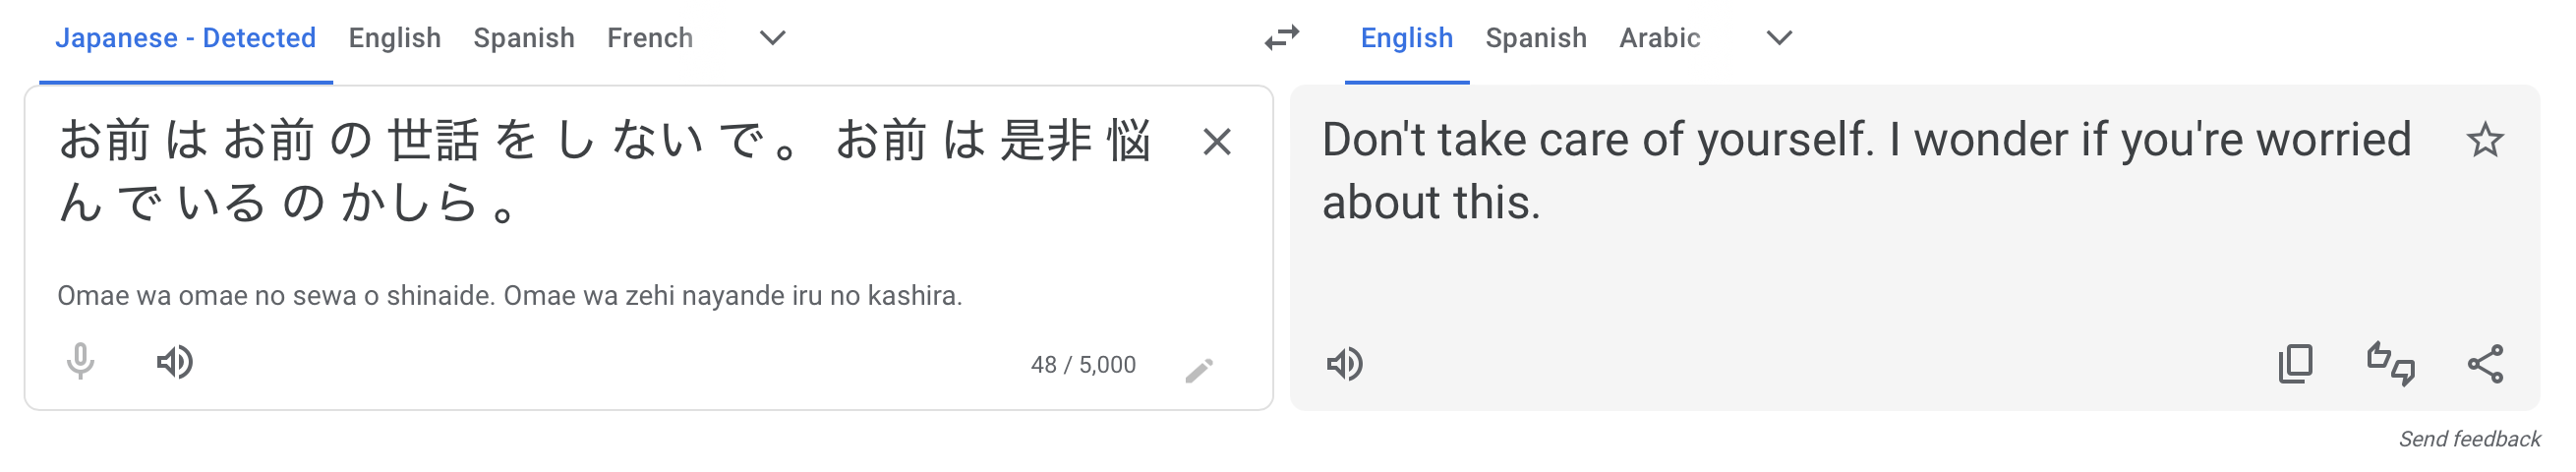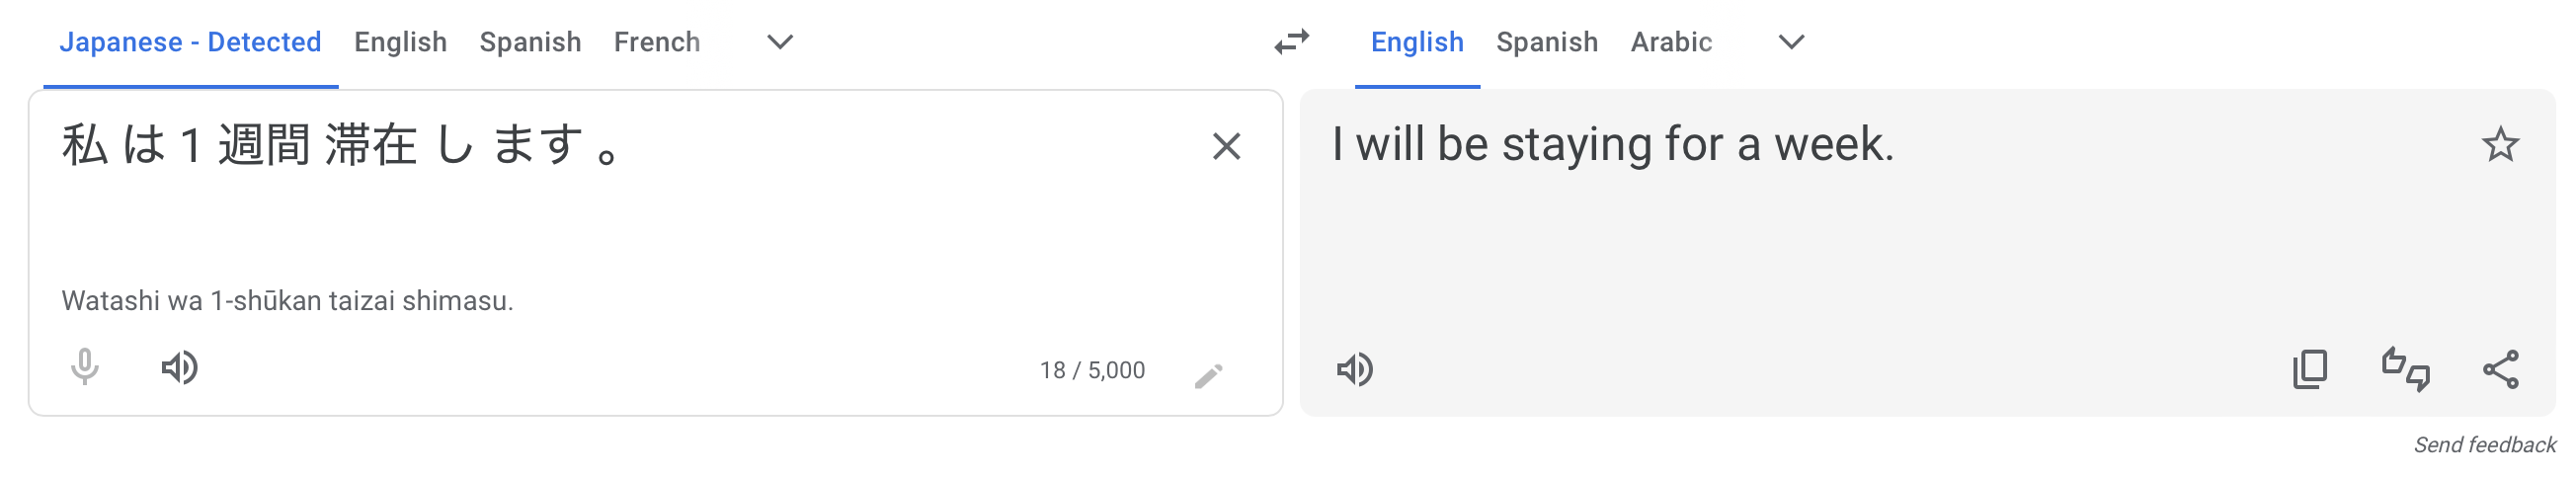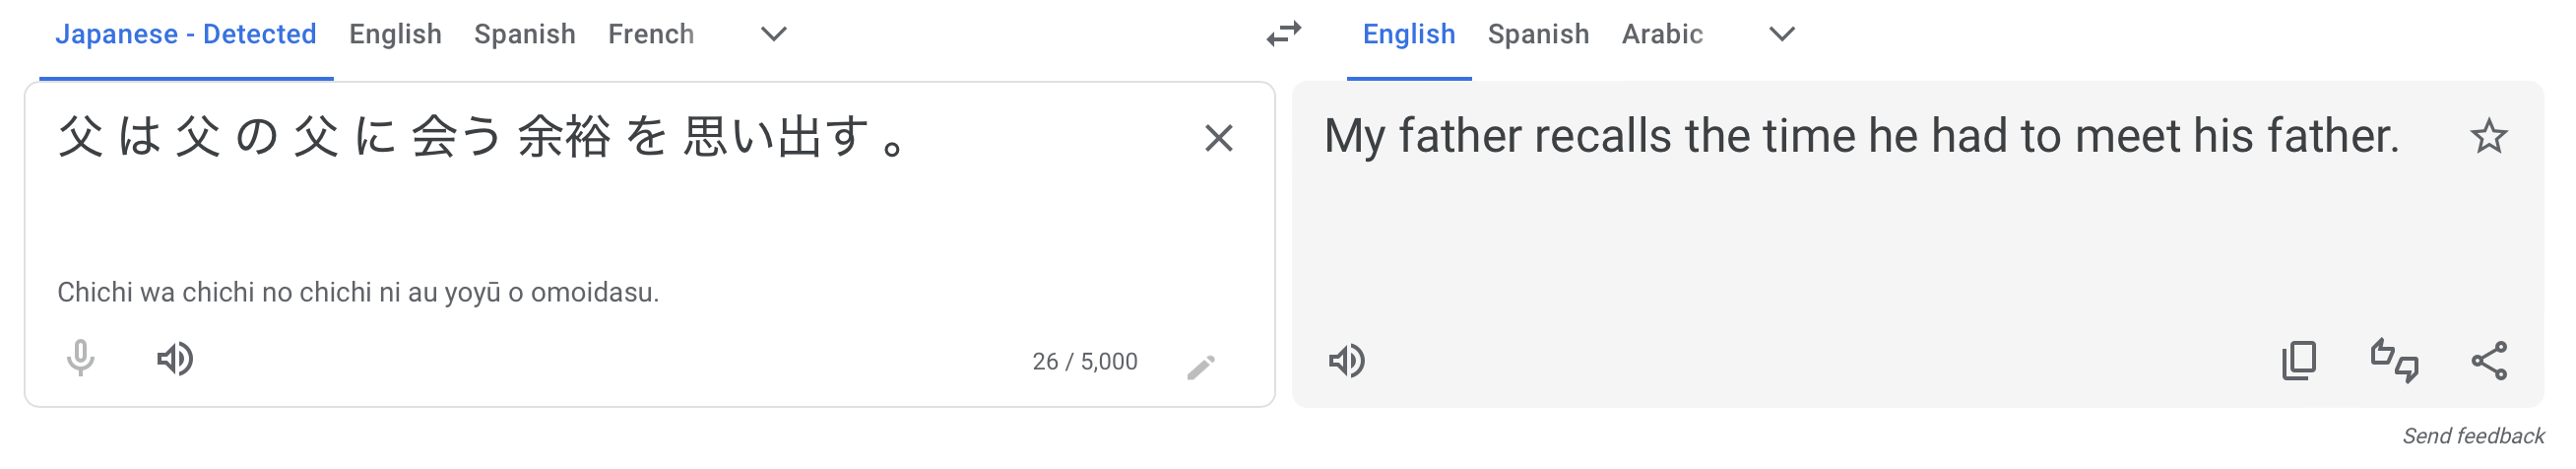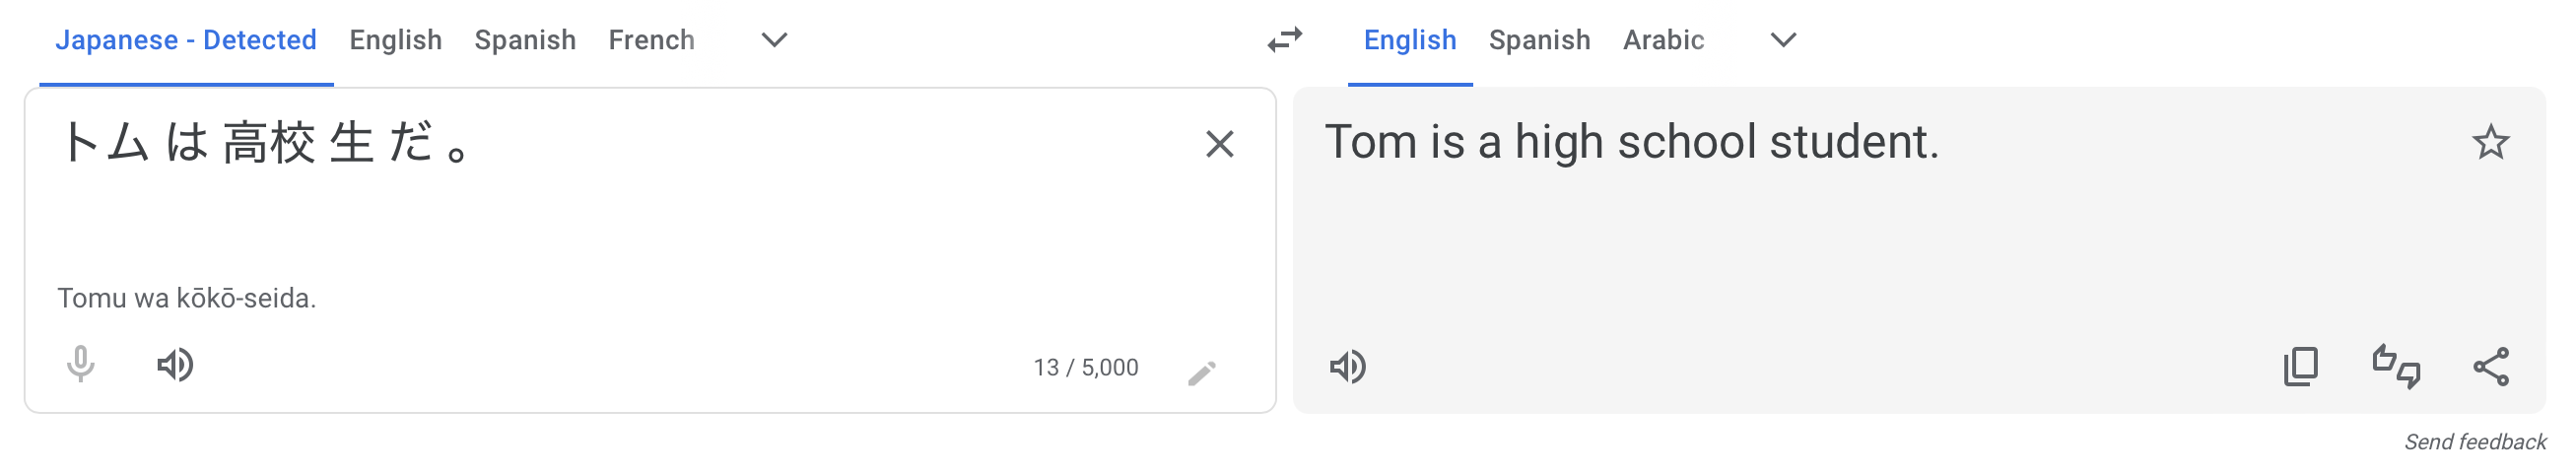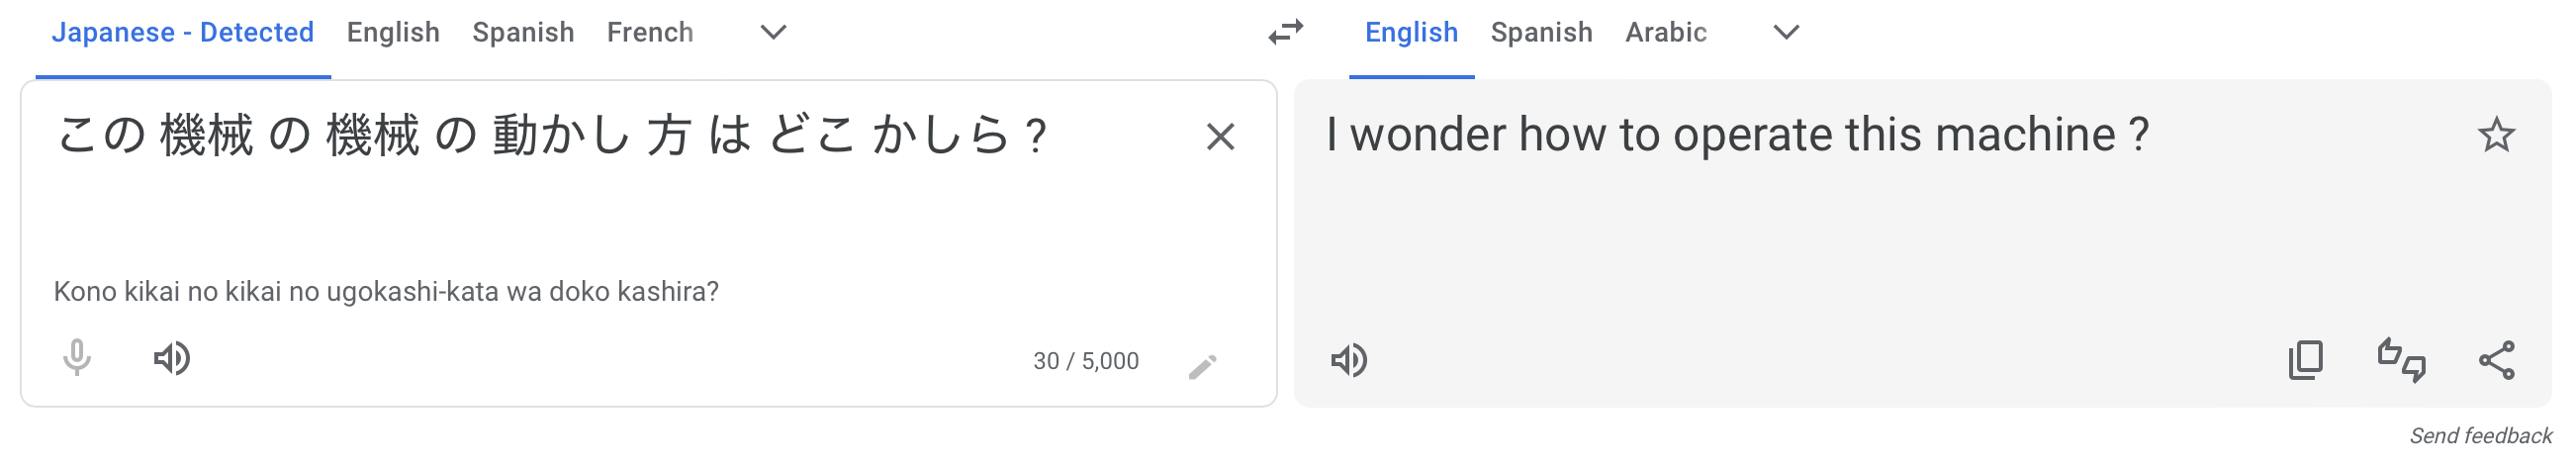

This is the end of this notebook. If you have any suggestion or question for my code, feel free to reach out to me on LinkedIn: https://www.linkedin.com/in/saberyu/. I hope you found this notebook fun and helpful!

---

